# BÁO CÁO DỰ ÁN DỰ ĐOÁN GIÁ NHÀ
## I. GIỚI THIỆU VÀ MỤC TIÊU

In [2]:
# THƯ VIỆN CƠ BẢN VÀ XỬ LÝ DỮ LIỆU
import pandas as pd
import numpy as np
from typing import Optional

# THƯ VIỆN TRỰC QUAN HÓA VÀ THỐNG KÊ (Cho bước EDA)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew # Để kiểm tra độ lệch
import os

# THƯ VIỆN MACHINE LEARNING VÀ XỬ LÝ MÔ HÌNH
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# CÁC MÔ HÌNH HỒI QUY CƠ SỞ
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer

# THƯ VIỆN LƯU VÀ TẢI MÔ HÌNH
import joblib

# THƯ VIỆN FASTAPI VÀ PYDANTIC
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn

In [3]:
from google.colab import files
import pandas as pd
import io

# Tải file lên từ máy tính của bạn khi chạy ô này
print("Vui lòng chọn file 'data.xlsx' từ máy tính của bạn.")
uploaded = files.upload()

# Lấy nội dung file và đọc nó
FILE_NAME = 'data.xlsx'

if FILE_NAME in uploaded:
    # Đọc nội dung byte của file Excel đã tải lên
    df = pd.read_excel(io.BytesIO(uploaded[FILE_NAME]))
    print(f"\nINFO: Đã tải thành công dữ liệu với {len(df)} bản ghi.")

    # Hiển thị 5 dòng đầu tiên để xác nhận
    print("\n--- 5 DÒNG DỮ LIỆU ĐẦU TIÊN ---")
    display(df.head())

else:
    # Trường hợp bạn đã tải file lên nhưng không chọn nó trong hộp thoại
    print(f"\nCẢNH BÁO: Không tìm thấy file {FILE_NAME} trong lượt tải lên. Thử đọc lại file từ thư mục gốc...")
    try:
        df = pd.read_excel(FILE_NAME)
        print(f"INFO: Đã tải thành công dữ liệu với {len(df)} bản ghi (Đọc từ thư mục gốc).")
        display(df.head())
    except Exception as e:
        print(f"LỖI: Không thể tải dữ liệu bằng cả hai cách. Lỗi: {e}")

Vui lòng chọn file 'data.xlsx' từ máy tính của bạn.


Saving data.xlsx to data (3).xlsx

CẢNH BÁO: Không tìm thấy file data.xlsx trong lượt tải lên. Thử đọc lại file từ thư mục gốc...
INFO: Đã tải thành công dữ liệu với 4600 bản ghi (Đọc từ thư mục gốc).


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


## II. TIỀN XỬ LÝ DỮ LIỆU & EDA
### 1. Phân tích Dữ liệu Khám phá (EDA)

In [4]:
# --- CODE PHÂN TÍCH CẤU TRÚC DỮ LIỆU VÀ ĐỘ LỆCH (SKEWNESS) ---

CONTINUOUS_COLS = ['price', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'bedrooms', 'view', 'condition', 'waterfront']
DATE_COL = 'date'
ID_COL = ['street', 'statezip', 'city', 'country']
TIME_COLS = ['yr_built', 'yr_renovated']
ALL_COLS = CONTINUOUS_COLS + [DATE_COL] + ID_COL

print("--- 1. Bắt đầu Tiền xử lý Bắt buộc ---")
print(f"Dòng ban đầu: {len(df)}")

# --- A. XỬ LÝ ID (Luôn xóa NaN và Trùng lặp) ---
df.dropna(subset=ID_COL, inplace=True)
df.drop_duplicates(subset=ID_COL, keep='first', inplace=True)
print(f"Dòng sau khi xóa NaN & Trùng lặp ID: {len(df)}")

# --- B. XỬ LÝ LỖI DỮ LIỆU & CHUYỂN ĐỔI KIỂU DỮ LIỆU (Tạo NaN) ---
# 1. Quét lỗi text phổ biến
for col in df.columns:
    if df[col].dtype == 'object':
        df.loc[df[col].astype(str).str.contains('ERROR|UNKNOWN|^$', na=False, regex=True, case=False), col] = np.nan

# 2. Xử lý các cột số (CONTINUOUS)
for col in CONTINUOUS_COLS + TIME_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Xử lý Cột Date (Chỉ nên xóa NaN cho cột date)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
df.dropna(subset=[DATE_COL], inplace=True)
print(f"Dòng sau khi xóa NaN cho DATE: {len(df)}")

print("\nCấu trúc Dữ liệu")
print(f"-> Kích thước: {df.shape[0]} dòng, {df.shape[1]} cột.")

# Hiển thị tóm tắt kiểu dữ liệu và NaN
df.info()

print("\nPhân tích Biến Mục tiêu (price)")

# Xử lý các giá trị không phải số trong cột 'price' (chuyển sang NaN)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
# Loại bỏ NaN tạm thời để tính toán skewness
price_data = df['price'].dropna()
initial_skew = skew(price_data)

print(f"-> Độ lệch (Skewness) ban đầu của Price: {initial_skew:.4f}")

# Quyết định kỹ thuật: Nếu skew > 0.5, cần Log Transformation
if initial_skew > 0.5:
    print("-> NHẬN ĐỊNH: Giá trị Skewness cao, cần áp dụng Log Transformation.")

--- 1. Bắt đầu Tiền xử lý Bắt buộc ---
Dòng ban đầu: 4600
Dòng sau khi xóa NaN & Trùng lặp ID: 4526
Dòng sau khi xóa NaN cho DATE: 4526

Cấu trúc Dữ liệu
-> Kích thước: 4526 dòng, 18 cột.
<class 'pandas.core.frame.DataFrame'>
Index: 4526 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4526 non-null   datetime64[ns]
 1   price          4526 non-null   float64       
 2   bedrooms       4526 non-null   int64         
 3   bathrooms      4526 non-null   float64       
 4   sqft_living    4526 non-null   int64         
 5   sqft_lot       4526 non-null   int64         
 6   floors         4526 non-null   float64       
 7   waterfront     4526 non-null   int64         
 8   view           4526 non-null   int64         
 9   condition      4526 non-null   int64         
 10  sqft_above     4526 non-null   int64         
 11  sqft_basement  4526 non-null   int64      

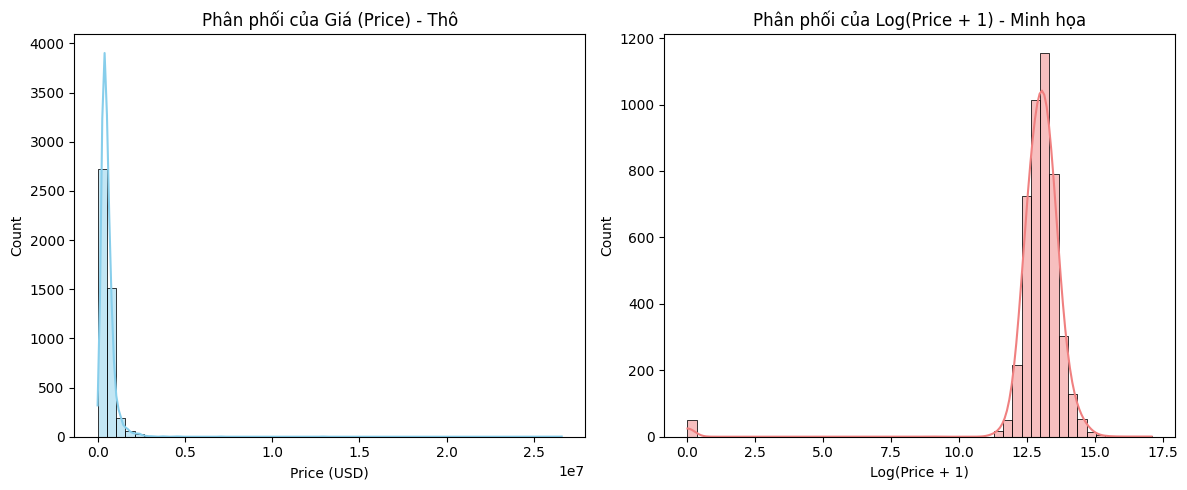

In [5]:
# --- CODE TẠO BIỂU ĐỒ PHÂN PHỐI PRICE ---

plt.figure(figsize=(12, 5))

# Biểu đồ 1: Phân phối thô
plt.subplot(1, 2, 1)
sns.histplot(price_data, kde=True, bins=50, color='skyblue')
plt.title('Phân phối của Giá (Price) - Thô')
plt.xlabel('Price (USD)')

# Biểu đồ 2: Phân phối sau Log (Minh họa)
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(price_data), kde=True, bins=50, color='lightcoral')
plt.title('Phân phối của Log(Price + 1) - Minh họa')
plt.xlabel('Log(Price + 1)')

plt.tight_layout()
plt.show()

# Lưu ý: Do độ lệch cao, chúng ta sẽ áp dụng Log Transformation trong bước tiền xử lý chính thức.
df['price_log'] = np.log1p(df['price'])


Phân tích Tương quan (giữa các biến số với Price)


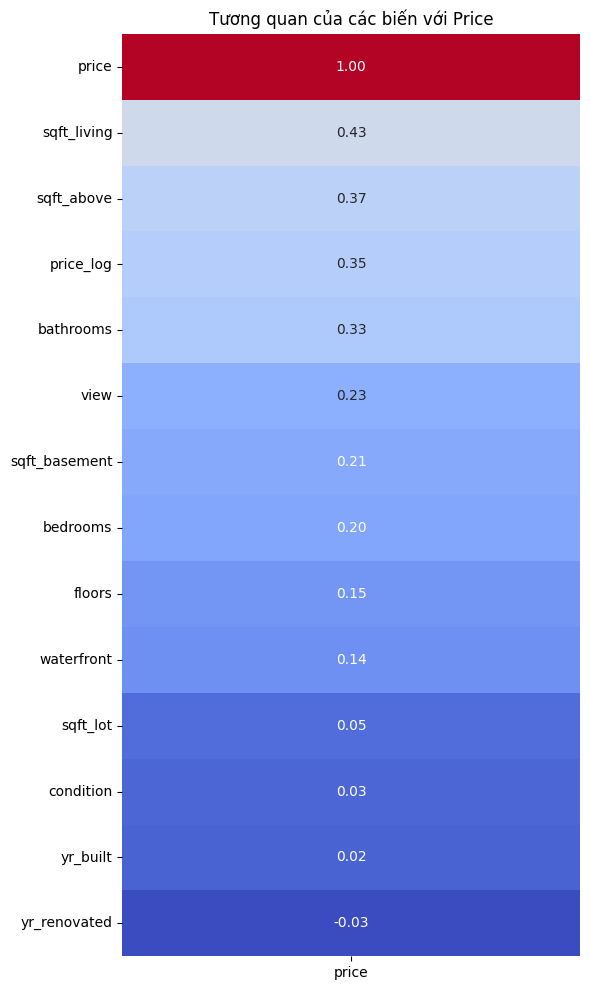


--- Top 5 Đặc trưng tương quan mạnh với Price (thô) ---
price          1.000000
sqft_living    0.430109
sqft_above     0.367675
price_log      0.345305
bathrooms      0.328018
Name: price, dtype: float64


In [6]:
# --- CODE PHÂN TÍCH TƯƠNG QUAN VÀ HEATMAP ---

print("\nPhân tích Tương quan (giữa các biến số với Price)")

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# Tính toán ma trận tương quan trên các cột số
correlation_matrix = df[numerical_cols].corr()

# --- TẠO BIỂU ĐỒ HEATMAP CHO TƯƠNG QUAN VỚI PRICE ---
plt.figure(figsize=(6, 10))
sns.heatmap(
    correlation_matrix[['price']].sort_values(by='price', ascending=False),
    annot=True, # Hiển thị giá trị số trên ô
    cmap='coolwarm',
    fmt=".2f",
    cbar=False # Có thể bỏ thanh màu nếu chỉ tập trung vào Price
)
plt.title('Tương quan của các biến với Price')
plt.tight_layout()
plt.show() # Hiển thị Heatmap

# Hiển thị Top 5 đặc trưng có tương quan mạnh nhất
top_correlations = correlation_matrix['price'].abs().sort_values(ascending=False).head(5)
print("\n--- Top 5 Đặc trưng tương quan mạnh với Price (thô) ---")
print(top_correlations)

## III. KỸ THUẬT ĐẶC TRƯNG (FEATURE ENGINEERING)

Trong giai đoạn này, em tạo ra các đặc trưng mới có ý nghĩa hơn từ các biến thô ban đầu, đặc biệt là các biến liên quan đến thời gian và kích thước, nhằm cải thiện khả năng dự đoán của mô hình.

### 1. Tạo Biến Thời gian và Tuổi Nhà

Em chuyển đổi các cột năm xây dựng (`yr_built`) và năm cải tạo (`yr_renovated`) thành các biến về tuổi nhà (Age) và tuổi cải tạo (AgeRenovated), vì tuổi thọ của ngôi nhà có tương quan mạnh mẽ với giá trị.

In [7]:
DATE_COL = 'date'
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

print("\n--- 1. TẠO BIẾN THỜI GIAN (FEATURE ENGINEERING) ---")

# 1. Tách Năm Bán
df['yr_sold'] = df[DATE_COL].dt.year
print(f"INFO: Đã tách năm bán ('yr_sold').")

# 2. Tính Age (Tuổi nhà)
df['Age'] = df['yr_sold'] - df['yr_built']
# Xử lý lỗi nếu Age < 0
df['Age'] = df['Age'].apply(lambda x: 0 if x < 0 else x)

# 3. Tính AgeRenovated (Tuổi cải tạo)
# Nếu yr_renovated > 0, tính tuổi cải tạo; ngược lại, dùng tuổi nhà (Age)
df['AgeRenovated'] = np.where(
    df['yr_renovated'] > 0,
    df['yr_sold'] - df['yr_renovated'],
    df['Age']
)

# Đảm bảo AgeRenovated không âm
df['AgeRenovated'] = df['AgeRenovated'].apply(lambda x: 0 if x < 0 else x)

# Loại bỏ các cột năm ban đầu và yr_sold
df.drop(columns=['yr_built', 'yr_renovated', 'yr_sold', DATE_COL], inplace=True)
print(f"-> Đã tạo Age và AgeRenovated và xóa cột thô.")
print(f"INFO: DataFrame hiện có {df.shape[1]} cột.")
display(df[['Age', 'AgeRenovated']].head())


--- 1. TẠO BIẾN THỜI GIAN (FEATURE ENGINEERING) ---
INFO: Đã tách năm bán ('yr_sold').
-> Đã tạo Age và AgeRenovated và xóa cột thô.
INFO: DataFrame hiện có 18 cột.


,Age,AgeRenovated
0,59,9
1,93,93
2,48,48
3,51,51
4,38,22


### 2. Chuẩn hóa Biến Mục tiêu và Xử lý Ngoại lai

Dựa trên phân tích EDA ở Chương II (độ lệch Skewness cao), em thực hiện các bước sau để đảm bảo phân phối biến mục tiêu gần với phân phối chuẩn (Gaussian distribution) hơn, đồng thời loại bỏ các giá trị ngoại lai có thể làm sai lệch mô hình.


--- CHUẨN HÓA BIẾN MỤC TIÊU (PRICE) ---
-> Đã tạo cột price_log (log(price + 1)).
-> Đã xóa 119 hàng ngoại lai dựa trên price_log (Sử dụng IQR).
-> Số dòng còn lại sau khi xóa ngoại lai: 4407
-> Độ lệch (Skewness) của Price sau khi xử lý: 0.1206


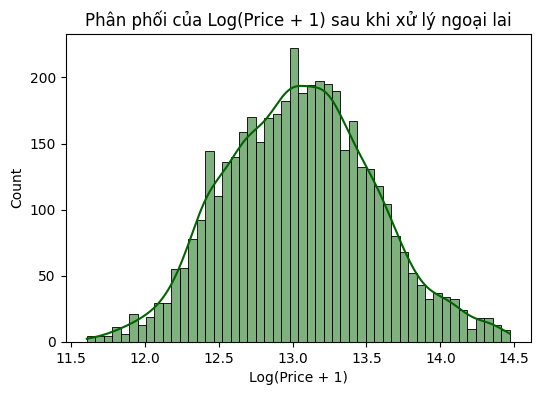

In [8]:
# --- CODE CHUẨN HÓA BIẾN MỤC TIÊU VÀ XỬ LÝ NGOẠI LAI ---

print("\n--- CHUẨN HÓA BIẾN MỤC TIÊU (PRICE) ---")

# 1. Áp dụng Log Transformation (np.log1p)
df['price_log'] = np.log1p(df['price'])
print(f"-> Đã tạo cột price_log (log(price + 1)).")

# 2. Xử lý Ngoại lai bằng IQR trên price_log
# Tính toán Tứ phân vị (Quartiles)
Q1 = df['price_log'].quantile(0.25)
Q3 = df['price_log'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc và xóa các hàng có price_log nằm ngoài giới hạn IQR
df_filtered = df[
    (df['price_log'] >= lower_bound) &
    (df['price_log'] <= upper_bound)
].copy() # Sử dụng .copy() để tránh SettingWithCopyWarning

num_removed = len(df) - len(df_filtered)
df = df_filtered
print(f"-> Đã xóa {num_removed} hàng ngoại lai dựa trên price_log (Sử dụng IQR).")
print(f"-> Số dòng còn lại sau khi xóa ngoại lai: {len(df)}")

# 3. Tính lại Skewness (Kiểm tra kết quả sau khi xử lý)
from scipy.stats import skew # Đảm bảo đã import
current_skew = skew(df['price_log'])
print(f"-> Độ lệch (Skewness) của Price sau khi xử lý: {current_skew:.4f}")

# Hiển thị phân phối mới để xác nhận
plt.figure(figsize=(6, 4))
sns.histplot(df['price_log'], kde=True, bins=50, color='darkgreen')
plt.title('Phân phối của Log(Price + 1) sau khi xử lý ngoại lai')
plt.xlabel('Log(Price + 1)')
plt.show()

### 3. Gộp nhóm và Mã hóa Biến Phân loại (City)

Biến `city` có quá nhiều giá trị duy nhất (High Cardinality), điều này có thể làm mô hình bị quá khớp (Overfitting) hoặc làm giảm hiệu suất. Em áp dụng chiến lược gộp nhóm các thành phố có tỷ lệ xuất hiện dưới 1.0% vào nhóm **'Other_City'** trước khi thực hiện mã hóa One-Hot Encoding (OHE).

In [9]:
# --- CODE GỘP NHÓM CITY VÀ ONE-HOT ENCODING ---

# 1. Định nghĩa các cột thừa cần xóa (đã được sử dụng/xác nhận là không cần thiết)
COLS_TO_DROP_FINALLY = ['street', 'statezip', 'country']

# 4.2. Hiển thị phân phối TẤT CẢ Thành phố (City)
city_counts = df['city'].value_counts()
city_percentages = df['city'].value_counts(normalize=True).mul(100).round(2)

city_distribution = pd.DataFrame({
    'Count': city_counts,
    'Percentage': city_percentages.astype(str) + '%'
})

print("-> Phân phối TẤT CẢ Thành phố (City - Tần suất và Tỷ lệ):")
print(f"Tổng số thành phố duy nhất: {len(city_distribution)}")
print(city_distribution)

# Gộp nhóm CITY (Ngưỡng 1.0%)
print("\n-> Bắt đầu Gộp nhóm và Mã hóa City (Ngưỡng 1.0%)...")
# Tính tỷ lệ phần trăm của mỗi thành phố
city_counts_normalized = df['city'].value_counts(normalize=True)

# Lấy danh sách các thành phố lớn (tỷ lệ >= 1.0%)
large_cities = city_counts_normalized[city_counts_normalized >= 0.01].index.tolist()

# Gán 'Other_City' cho các thành phố nhỏ hơn 1.0%
df['city_grouped'] = df['city'].apply(lambda x: x if x in large_cities else 'Other_City')

print(f"-> Đã gộp nhóm: {len(large_cities)} thành phố lớn được giữ lại.")
print(f"-> Số lượng nhóm city cuối cùng: {df['city_grouped'].nunique()}")

# Mã hóa One-Hot Encoding cho cột city_grouped
df = pd.get_dummies(df, columns=['city_grouped'], prefix='city', dtype=int)
print("-> Đã thực hiện One-Hot Encoding cho city_grouped.")

# Loại bỏ cột 'city' ban đầu
df.drop(columns=['city'], inplace=True)

# Loại bỏ các cột thừa
df.drop(columns=COLS_TO_DROP_FINALLY, inplace=True)
print(f"-> Đã xóa các cột thừa: {COLS_TO_DROP_FINALLY}")

# --- C. Xóa các hàng còn sót lại NaN (trường hợp hiếm) ---
df.dropna(inplace=True)

print(f"\n--- TIỀN XỬ LÝ HOÀN TẤT ---")
print(f"DataFrame cuối cùng có {df.shape[0]} dòng và {df.shape[1]} cột.")
display(df.head())

# LƯU DỮ LIỆU ĐÃ TIỀN XỬ LÝ
CLEANED_FILE_PATH = 'cleaned_data.xlsx'
try:
    df.to_excel(CLEANED_FILE_PATH, index=False)
    print(f"\nINFO QUAN TRỌNG: Đã lưu dữ liệu đã tiền xử lý vào file '{CLEANED_FILE_PATH}'.")
except Exception as e:
    print(f"\nLỖI LƯU FILE: Không thể lưu cleaned_data.xlsx. Lỗi: {e}")

-> Phân phối TẤT CẢ Thành phố (City - Tần suất và Tỷ lệ):
Tổng số thành phố duy nhất: 44
                     Count Percentage
city                                 
Seattle               1511     34.29%
Renton                 287      6.51%
Bellevue               269       6.1%
Redmond                231      5.24%
Kirkland               180      4.08%
Kent                   180      4.08%
Issaquah               178      4.04%
Auburn                 172       3.9%
Sammamish              166      3.77%
Federal Way            145      3.29%
Shoreline              120      2.72%
Woodinville            113      2.56%
Maple Valley            91      2.06%
Mercer Island           72      1.63%
Burien                  69      1.57%
Kenmore                 65      1.47%
Snoqualmie              64      1.45%
Des Moines              58      1.32%
North Bend              48      1.09%
Duvall                  42      0.95%
Covington               39      0.88%
Lake Forest Park        33      0.75%

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,...,city_Mercer Island,city_North Bend,city_Other_City,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Shoreline,city_Snoqualmie,city_Woodinville
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,...,0,0,0,0,0,0,0,1,0,0
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,...,0,0,0,0,0,0,0,0,0,0
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,...,0,0,0,0,0,0,0,0,0,0
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,...,0,0,0,1,0,0,0,0,0,0
5,490000.0,2,1.00,880,6380,1.0,0,0,3,880,...,0,0,0,0,0,0,1,0,0,0



INFO QUAN TRỌNG: Đã lưu dữ liệu đã tiền xử lý vào file 'cleaned_data.xlsx'.


## IV. HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH CƠ SỞ

Giai đoạn này tập trung vào việc thiết lập các mô hình cơ sở (Baseline Models) và đánh giá hiệu suất của chúng bằng chỉ số **RMSLE (Root Mean Squared Log Error)**, chỉ số phù hợp nhất cho bài toán dự đoán giá nhà.

### 1. Định nghĩa Hàm Đánh giá RMSLE

In [10]:
def rmsle(y_true, y_pred):
    #Tính chỉ số Root Mean Squared Log Error (RMSLE).
    # Chuyển đổi ngược từ log(x+1) về x (giá trị price ban đầu)
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)

    # Áp dụng công thức RMSLE: sqrt(MSE(log(y+1) - log(y_pred+1)))
    return np.sqrt(mean_squared_error(np.log1p(y_true_exp), np.log1p(y_pred_exp)))

# Tạo RMSLE Scorer cho GridSearchCV (Lưu ý: GridSearchCV tìm kiếm MINIMUM score, nên phải đảo ngược dấu)
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

print("-> Đã định nghĩa hàm đánh giá RMSLE.")

-> Đã định nghĩa hàm đánh giá RMSLE.


In [11]:
# --- 2. CHUẨN BỊ VÀ TÁCH DỮ LIỆU ---

# Tải lại dữ liệu đã làm sạch từ file Excel (mô phỏng)
try:
    # Tải lại DataFrame từ file đã lưu
    df = pd.read_excel('cleaned_data.xlsx')
    print(f"INFO: Đã tải lại dữ liệu đã làm sạch với {len(df)} dòng và {len(df.columns)} cột.")
except FileNotFoundError:
    # Nếu không tìm thấy file, sẽ sử dụng df đã có sẵn trong bộ nhớ (nếu đã chạy các bước trước)
    print("CẢNH BÁO: Không tìm thấy file 'cleaned_data.xlsx'. Đang sử dụng DataFrame 'df' trong bộ nhớ.")

# Định nghĩa Biến độc lập (X) và Biến phụ thuộc (Y)
# Loại bỏ 'price' (giá thô), 'price_log' là Y, và 'date'
# Chỉ cần loại bỏ cột 'price' (thô) để giữ lại 'price_log' là biến mục tiêu Y.
X = df.drop(columns=['price', 'price_log'])
Y = df['price_log'] # Sử dụng biến mục tiêu đã được log-transform

# Tên các cột số cần Standard Scaling (TẤT CẢ CÁC CỘT TRỪ các cột OHE)
# Sau bước OHE, tất cả các cột của X đều là số, nên ta scale tất cả.
numerical_cols_to_scale = X.columns.tolist()

# Chia tập dữ liệu (Test size 20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"-> Tập huấn luyện (Training set): {len(X_train)} mẫu ({X_train.shape[1]} đặc trưng).")
print(f"-> Tập kiểm tra (Testing set): {len(X_test)} mẫu.")

# Cấu hình K-Fold (Dùng 5 folds cho tốc độ)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_results = {}

# --- HUẤN LUYỆN VÀ LƯU SCALER ---
# Fit Scaler chỉ trên tập huấn luyện (X_train) để tránh Data Leakage
scaler_model = StandardScaler()
scaler_model.fit(X_train[numerical_cols_to_scale])
joblib.dump(scaler_model, 'standard_scaler_final.pkl')
print("-> Đã huấn luyện và lưu standard_scaler_final.pkl.")

INFO: Đã tải lại dữ liệu đã làm sạch với 4407 dòng và 34 cột.
-> Tập huấn luyện (Training set): 3525 mẫu (32 đặc trưng).
-> Tập kiểm tra (Testing set): 882 mẫu.
-> Đã huấn luyện và lưu standard_scaler_final.pkl.


In [12]:
# --- 3. HUẤN LUYỆN CÁC MÔ HÌNH HỒI QUY TUYẾN TÍNH (Baseline) ---

# Các mô hình tuyến tính cần Standard Scaling
models = {
    "Linear Regression (Baseline)": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10.0),
    "Lasso Regression": Lasso(alpha=0.001, max_iter=10000),
    "Elastic Net Regression": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
}

results = {}

print("\n--- BẮT ĐẦU HUẤN LUYỆN VÀ ĐÁNH GIÁ BASELINE ---")
for name, model in models.items():
    print(f"\nĐang huấn luyện: {name}...")

    # Tạo Pipeline: Tích hợp Scaling và Mô hình
    full_pipeline = Pipeline(steps=[
        ('scaler', scaler_model),
        ('regressor', model)
    ])

    # Huấn luyện mô hình
    full_pipeline.fit(X_train, Y_train)

    # Dự đoán trên tập kiểm tra
    Y_pred = full_pipeline.predict(X_test)

    # Đánh giá bằng RMSLE
    score = rmsle(Y_test, Y_pred)
    results[name] = score
    print(f"-> {name} - RMSLE: {score:.4f}")

    if name == "Linear Regression (Baseline)":
        # 1. Lưu mô hình Pipeline (final_linear_model.pkl)
        joblib.dump(full_pipeline, 'final_linear_model.pkl')
        print(f"-> ĐÃ LƯU: Mô hình Pipeline '{name}' vào file 'final_linear_model.pkl'.")

        # 2. LƯU DỰ ĐOÁN (Y_pred) CỦA LINEAR REGRESSION
        # Lưu dưới dạng mảng numpy để dễ dàng tải lại và sử dụng
        Y_pred_linear = Y_pred
        joblib.dump(Y_pred_linear, 'Y_pred_linear.pkl')
        print(f"-> ĐÃ LƯU: Dự đoán Y_pred của LR vào file 'Y_pred_linear.pkl'.")

all_results.update(results)
print("\n--- KẾT QUẢ CÁC MÔ HÌNH TUYẾN TÍNH ---")
display(pd.DataFrame(list(results.items()), columns=['Model', 'RMSLE Score']))


--- BẮT ĐẦU HUẤN LUYỆN VÀ ĐÁNH GIÁ BASELINE ---

Đang huấn luyện: Linear Regression (Baseline)...
-> Linear Regression (Baseline) - RMSLE: 0.2640
-> ĐÃ LƯU: Mô hình Pipeline 'Linear Regression (Baseline)' vào file 'final_linear_model.pkl'.
-> ĐÃ LƯU: Dự đoán Y_pred của LR vào file 'Y_pred_linear.pkl'.

Đang huấn luyện: Ridge Regression...
-> Ridge Regression - RMSLE: 0.2640

Đang huấn luyện: Lasso Regression...
-> Lasso Regression - RMSLE: 0.2641

Đang huấn luyện: Elastic Net Regression...
-> Elastic Net Regression - RMSLE: 0.2654

--- KẾT QUẢ CÁC MÔ HÌNH TUYẾN TÍNH ---


,Model,RMSLE Score
0,Linear Regression (Baseline),0.263994
1,Ridge Regression,0.263965
2,Lasso Regression,0.264094
3,Elastic Net Regression,0.265419


### 4. Tinh chỉnh Siêu Tham số (Hyperparameter Tuning)

Em sử dụng kỹ thuật **Tìm kiếm Lưới (Grid Search)** kết hợp với **Cross-Validation K-Fold (k=5)** để tìm ra bộ siêu tham số tối ưu nhất cho các mô hình Ridge, Lasso và XGBoost, nhằm tối đa hóa hiệu suất đánh giá bằng chỉ số RMSLE.

[Image of Grid Search Cross-Validation]

In [13]:
print("\n--- A. TINH CHỈNH SIÊU THAM SỐ CHO RIDGE ---")
ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(random_state=42))])

ridge_params = {
    'alpha': [1.0, 5.0, 10.0, 20.0, 50.0, 100.0] # Tham số Regularization L2
}

ridge_grid = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=ridge_params,
    scoring=rmsle_scorer,
    cv=kf,
    verbose=1,
    n_jobs=-1
)

ridge_grid.fit(X_train, Y_train)
ridge_best = ridge_grid.best_estimator_
Y_pred_ridge = ridge_best.predict(X_test)
ridge_rmsle = rmsle(Y_test, Y_pred_ridge)

all_results["Ridge (Tuned)"] = ridge_rmsle
print(f"-> Ridge Best Params: {ridge_grid.best_params_}")
print(f"-> Ridge (Tuned) RMSLE trên Test Set: {ridge_rmsle:.4f}")

print("\n--- B. TINH CHỈNH SIÊU THAM SỐ CHO LASSO ---")
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(random_state=42))])

lasso_params = {
    'alpha': [0.0005, 0.001, 0.002, 0.005], # Tham số Regularization L1
    'max_iter': [20000]
}

lasso_grid = GridSearchCV(
    estimator=Lasso(random_state=42),
    param_grid=lasso_params,
    scoring=rmsle_scorer,
    cv=kf,
    verbose=1,
    n_jobs=-1
)

lasso_grid.fit(X_train, Y_train)
lasso_best = lasso_grid.best_estimator_
Y_pred_lasso = lasso_best.predict(X_test)
lasso_rmsle = rmsle(Y_test, Y_pred_lasso)

all_results["Lasso (Tuned)"] = lasso_rmsle
print(f"-> Lasso Best Params: {lasso_grid.best_params_}")
print(f"-> Lasso (Tuned) RMSLE trên Test Set: {lasso_rmsle:.4f}")

print("\n--- C. TINH CHỈNH SIÊU THAM SỐ CHO XGBOOST ---")
# Phạm vi tham số nhỏ cho demo (có thể mở rộng sau)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5]
}

xgb_grid = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ),
    param_grid=xgb_params,
    scoring=rmsle_scorer,
    cv=kf,
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X_train, Y_train)
xgb_best = xgb_grid.best_estimator_
Y_pred_xgb = xgb_best.predict(X_test)
xgb_rmsle = rmsle(Y_test, Y_pred_xgb)

all_results["XGBoost (Tuned)"] = xgb_rmsle
print(f"-> XGBoost Best Params: {xgb_grid.best_params_}")
print(f"-> XGBoost (Tuned) RMSLE trên Test Set: {xgb_rmsle:.4f}")

joblib.dump(xgb_best, 'final_xgb_model.pkl')

print("\n--- LƯU KẾT QUẢ DỰ ĐOÁN ĐỂ ENSEMBLING ---")
# Lưu các mảng dự đoán cần thiết (Y_pred_xgb, Y_pred_linear)
joblib.dump(Y_pred_xgb, 'Y_pred_xgb.pkl')
# Lưu biến mục tiêu Y_test
joblib.dump(Y_test, 'Y_test_ensemble.pkl')

# 4. TỔNG KẾT KẾT QUẢ
print("\n--- TỔNG KẾT KẾT QUẢ ĐÁNH GIÁ ---")
results_df = pd.DataFrame(list(all_results.items()), columns=['Model', 'RMSLE Score'])
results_df = results_df.sort_values(by='RMSLE Score', ascending=True).reset_index(drop=True)
display(results_df)


--- A. TINH CHỈNH SIÊU THAM SỐ CHO RIDGE ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
-> Ridge Best Params: {'alpha': 1.0}
-> Ridge (Tuned) RMSLE trên Test Set: 0.2641

--- B. TINH CHỈNH SIÊU THAM SỐ CHO LASSO ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.088e+02, tolerance: 8.787e-02
  model = cd_fast.enet_coordinate_descent(


-> Lasso Best Params: {'alpha': 0.0005, 'max_iter': 20000}
-> Lasso (Tuned) RMSLE trên Test Set: 0.2651

--- C. TINH CHỈNH SIÊU THAM SỐ CHO XGBOOST ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
-> XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300}
-> XGBoost (Tuned) RMSLE trên Test Set: 0.2544

--- LƯU KẾT QUẢ DỰ ĐOÁN ĐỂ ENSEMBLING ---

--- TỔNG KẾT KẾT QUẢ ĐÁNH GIÁ ---


,Model,RMSLE Score
0,XGBoost (Tuned),0.254377
1,Ridge Regression,0.263965
2,Linear Regression (Baseline),0.263994
3,Lasso Regression,0.264094
4,Ridge (Tuned),0.264104
5,Lasso (Tuned),0.265112
6,Elastic Net Regression,0.265419


### 5. Phân tích Tầm quan trọng của Đặc trưng (Feature Importance)

Sau khi huấn luyện mô hình XGBoost tốt nhất, em phân tích các đặc trưng quan trọng nhất (Top 5) dựa trên chỉ số **Gain**. Chỉ số Gain thể hiện tổng lợi ích (tổng giảm thiểu lỗi) mà một đặc trưng mang lại cho toàn bộ cây quyết định. Điều này giúp em hiểu rõ hơn yếu tố nào ảnh hưởng mạnh mẽ nhất đến giá nhà.


--- Trực quan hóa Top 5 Feature Importance (Gain) ---


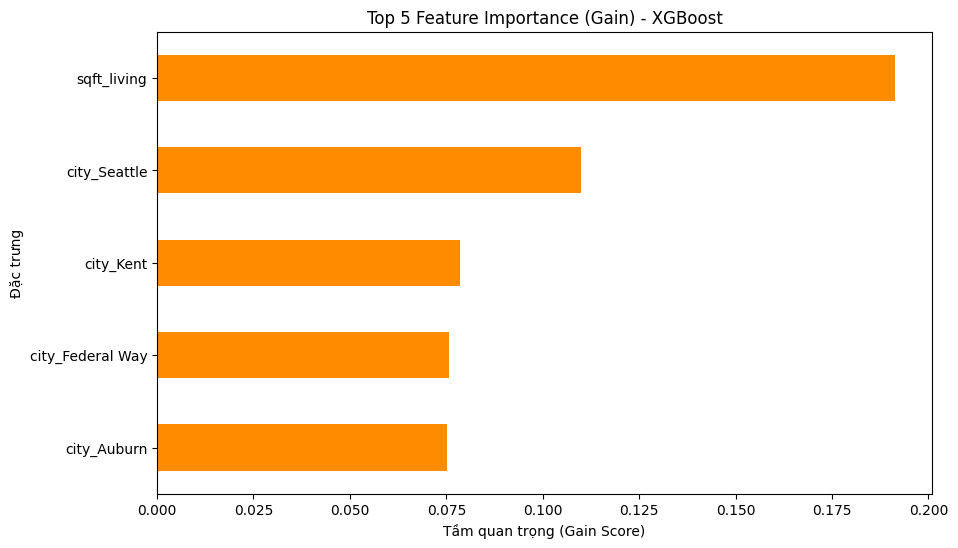


--- Top 5 Đặc Trưng Quan Trọng Nhất (theo Gain) ---
- sqft_living: 0.19135
- city_Seattle: 0.10998
- city_Kent: 0.07847
- city_Federal Way: 0.07580
- city_Auburn: 0.07529


In [14]:
# Tải mô hình XGBoost đã tinh chỉnh
try:
    xgb_model = joblib.load('final_xgb_model.pkl')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'final_xgb_model.pkl'. Vui lòng chạy bước Tinh chỉnh XGBoost trước.")
    exit()

# Lấy các giá trị quan trọng theo 'gain'
# Dùng thuộc tính feature_importances_ của estimator XGBoost
importance = xgb_model.feature_importances_

# Lấy tên các đặc trưng từ tập huấn luyện (X_train)
# (Cần đảm bảo X_train đã được định nghĩa ở các bước trước)
# NOTE: Nếu X_train chưa được định nghĩa, bạn cần định nghĩa lại nó.
# Giả định X_train đã có sẵn:
feature_names = X_train.columns.tolist()

# Tạo Series từ tên đặc trưng và giá trị importance
feature_series = pd.Series(importance, index=feature_names)

# Sắp xếp và chọn 5 đặc trưng quan trọng nhất
sorted_importance = feature_series.sort_values(ascending=False)
top_5_features = sorted_importance.head(5)

# --- TRỰC QUAN HÓA TOP 5 ---
print("\n--- Trực quan hóa Top 5 Feature Importance (Gain) ---")
plt.figure(figsize=(10, 6))
top_5_features.plot(kind='barh', color='darkorange')
plt.title('Top 5 Feature Importance (Gain) - XGBoost')
plt.xlabel('Tầm quan trọng (Gain Score)')
plt.ylabel('Đặc trưng')
plt.gca().invert_yaxis() # Đảo ngược trục Y để đặc trưng quan trọng nhất ở trên cùng

# Lưu và Hiển thị biểu đồ
plt.savefig('top_5_feature_importance.png')
plt.show()

# --- In ra 5 đặc trưng quan trọng nhất ---
print("\n--- Top 5 Đặc Trưng Quan Trọng Nhất (theo Gain) ---")
for feature, gain in top_5_features.items():
    print(f"- {feature}: {gain:,.5f}")

## V. MÔ HÌNH HỢP THỂ (ENSEMBLING) VÀ KẾT QUẢ CUỐI CÙNG

Trong giai đoạn này, em thực hiện kỹ thuật **Averaging Ensembling** (kết hợp trung bình có trọng số) giữa Mô hình Hồi quy Tuyến tính (Linear Regression) và Mô hình Gradient Boosting (XGBoost). Mục tiêu là tận dụng sự ổn định của LR và khả năng bắt các mối quan hệ phi tuyến tính của XGBoost để đạt được hiệu suất cao nhất.

In [15]:
def rmsle(y_true, y_pred):
    # Chuyển đổi ngược Log1P
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)

    # Tính toán RMSLE bằng cách sử dụng np.log1p cho tính ổn định
    return np.sqrt(mean_squared_error(np.log1p(y_true_exp), np.log1p(y_pred_exp)))


print("--- BẮT ĐẦU KẾT HỢP MÔ HÌNH (ENSEMBLING) ---")
# --- 1. Tải và Chuẩn bị Dữ liệu ---
try:
    Y_pred_linear = joblib.load('Y_pred_linear.pkl')
    Y_pred_xgb = joblib.load('Y_pred_xgb.pkl')
    Y_test = joblib.load('Y_test_ensemble.pkl')
    print("-> Tải thành công các dự đoán đã lưu.")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file dự đoán (.pkl). Vui lòng chạy train_model_tuned.py trước.")
    exit()

# Tính RMSLE của từng mô hình (để so sánh)
linear_rmsle = rmsle(Y_test, Y_pred_linear)
xgb_rmsle = rmsle(Y_test, Y_pred_xgb)

print("\n--- KẾT QUẢ MÔ HÌNH KẾT HỢP (XGBoost + Linear Regression) ---")
# Chúng ta sử dụng Averaging
Y_pred_ensemble = (Y_pred_xgb * 0.65) + (Y_pred_linear * 0.35)

# Đánh giá mô hình kết hợp
ensemble_rmsle = rmsle(Y_test, Y_pred_ensemble)

print("\n=======================================================")
print("             KẾT QUẢ SO SÁNH CUỐI CÙNG")
print("=======================================================")
print(f"| XGBoost (Tuned)                     | RMSLE: {xgb_rmsle:.4f} |")
print(f"| Linear Regression (Baseline)        | RMSLE: {linear_rmsle:.4f} |")
print(f"| ENSEMBLE (XGB + Linear)             | RMSLE: {ensemble_rmsle:.4f} |")
print("=======================================================")

if ensemble_rmsle < xgb_rmsle:
    print(f"\nCHÚC MỪNG! Mô hình Kết hợp đã cải thiện điểm số thêm {(xgb_rmsle - ensemble_rmsle) * 100:.3f} điểm phần trăm.")
else:
    print("\nKết quả: Mô hình Kết hợp không cải thiện được điểm số so với XGBoost đơn lẻ.")

print("\n*RMSLE càng nhỏ càng tốt. Mô hình tốt nhất là mô hình có RMSLE nhỏ nhất.")

--- BẮT ĐẦU KẾT HỢP MÔ HÌNH (ENSEMBLING) ---
-> Tải thành công các dự đoán đã lưu.

--- KẾT QUẢ MÔ HÌNH KẾT HỢP (XGBoost + Linear Regression) ---

             KẾT QUẢ SO SÁNH CUỐI CÙNG
| XGBoost (Tuned)                     | RMSLE: 0.2544 |
| Linear Regression (Baseline)        | RMSLE: 0.2640 |
| ENSEMBLE (XGB + Linear)             | RMSLE: 0.2505 |

CHÚC MỪNG! Mô hình Kết hợp đã cải thiện điểm số thêm 0.392 điểm phần trăm.

*RMSLE càng nhỏ càng tốt. Mô hình tốt nhất là mô hình có RMSLE nhỏ nhất.


## VI. TRIỂN KHAI VÀ MLOPS FOUNDATION

Mục tiêu của giai đoạn này là đóng gói mô hình đã huấn luyện và triển khai nó thành một dịch vụ web có thể truy cập công khai, đảm bảo tính ổn định và khả năng mở rộng.

### 1. Xây dựng và Tích hợp API (FastAPI)

Em sử dụng **FastAPI** để xây dựng dịch vụ dự đoán giá nhà, tận dụng tốc độ cao và khả năng tự động tạo tài liệu (Swagger UI).

#### 1.1. Model Serving: Tải Mô hình Toàn cục

Các mô hình Ensemble đã huấn luyện (**XGBoost** và **Linear Regression Pipeline**), cùng với danh sách cột chuẩn hóa, được tải vào bộ nhớ (RAM) ngay khi API khởi động (Global Loading). Điều này đảm bảo mỗi yêu cầu dự đoán được xử lý với độ trễ tối thiểu (latency).

#### 1.2. Thiết kế End-point và Xác thực Dữ liệu

* **End-point:** `/predict` (Phương thức POST).
* **Xác thực:** Sử dụng **Pydantic Schema** để định nghĩa và xác thực 14 đặc trưng đầu vào (ví dụ: `sqft_living`, `bedrooms`, `city`, `current_year`). Việc này ngăn chặn lỗi dữ liệu thiếu hoặc sai kiểu dữ liệu ngay từ đầu.

#### 1.3. Logic Tiền xử lý trong API

Dữ liệu thô từ request được xử lý nội bộ để khớp với định dạng huấn luyện mô hình:
1.  **Feature Engineering:** Tạo lại các biến như `age`, `age_renovated`.
2.  **One-Hot Encoding:** Chuyển đổi đặc trưng `city`.
3.  **Căn chỉnh Cột:** Căn chỉnh dữ liệu đã xử lý theo đúng **thứ tự và số lượng** cột (`X_train_cols`), gán giá trị 0 cho các cột OHE bị thiếu.

#### 1.4. Quy trình Dự đoán Cuối cùng

Tại End-point `/predict`, mô hình thực hiện:
1.  Dự đoán riêng biệt từ XGBoost và Linear Regression.
2.  Áp dụng **Weighted Averaging Ensemble** (trọng số 65/35).
3.  **Chuyển đổi Ngược Logarit** (`np.expm1`) để đưa kết quả về đơn vị tiền tệ gốc.

***

### 2. Đóng gói Môi trường (Dockerization)

Việc sử dụng Docker là nền tảng cốt lõi của MLOps, nhằm đảm bảo tính nhất quán giữa các môi trường.

#### 2.1. Lợi ích Chính

* **Tính Nhất quán (Consistency):** Loại bỏ lỗi "Nó chạy được trên máy tôi!" bằng cách đảm bảo môi trường (Python, thư viện, mô hình) trên máy cục bộ và máy chủ là hoàn toàn đồng nhất.
* **Đơn giản hóa Triển khai (Simplified Deployment):** Giúp quá trình triển khai lên các nền tảng đám mây (Render, AWS) trở nên đơn giản và đáng tin cậy.

#### 2.2. Kiểm thử Cục bộ (Local Verification)

Trước khi triển khai, container được xây dựng (`docker build`) và chạy cục bộ (`docker run`). Kiểm thử thành công bằng cách truy cập **Swagger UI** (`http://localhost:8000/docs`) xác nhận: API đã khởi động, mô hình đã tải, và end-point đã sẵn sàng.

### 3. Triển khai Lên Cloud (Render)

Em đã chọn Render để triển khai dịch vụ API đã được Docker hóa, tận dụng sự đơn giản và khả năng hỗ trợ Docker Image mạnh mẽ của nền tảng này.

#### 3.1. Chiến lược Deployment

Chiến lược triển khai sử dụng chính xác **Docker Image** đã được kiểm thử cục bộ, đảm bảo tính nhất quán (Reproducibility). Dịch vụ được triển khai dưới dạng **Web Service** trên Render, thiết kế để liên tục phục vụ các yêu cầu API qua HTTP.



#### 3.2. Cấu hình Quan trọng trên Render

Quá trình cấu hình tập trung vào việc liên kết kho chứa mã nguồn và chỉ định môi trường container:

| Thiết lập | Giá trị hoặc Giải thích | Mục đích |
| :--- | :--- | :--- |
| Loại Dịch vụ | Web Service | Đảm bảo container Docker luôn chạy để phục vụ các yêu cầu API. |
| Nguồn Triển khai | GitHub Repository | Tự động kết nối với kho chứa GitHub (chứa Dockerfile) để xây dựng Image. |
| Môi trường | Docker | Chỉ định Render sử dụng Dockerfile để xây dựng và chạy dự án. |
| Cổng (Port) | **8000** | Phải khớp chính xác với cổng được chỉ định trong lệnh `CMD` của Dockerfile. |

#### 3.3. Kiểm thử và Đường link Demo

Sau khi Render hoàn thành việc xây dựng và khởi chạy container, dịch vụ API đã được triển khai thành công và có thể truy cập.
* **Đường link Demo:** Dịch vụ API có thể được kiểm thử trực tiếp qua giao diện Swagger UI của FastAPI.

https://house-price-prediction-api-7wxj.onrender.com/docs

#### 3.4. Ghi chú về Vấn đề Khởi động (Startup Timeout)

* **Hiện tượng:** Do sử dụng gói **Free Tier** của Render, đôi khi có thể xảy ra lỗi HTTP 502 trong lần truy cập đầu tiên. Thường tốn 1-4 phút để khởi động.
* **Nguyên nhân:** Các mô hình Machine Learning lớn được tải vào bộ nhớ (Global Loading) trong quá trình khởi động. Tài nguyên giới hạn của gói Free Tier có thể không đủ mạnh để hoàn thành tác vụ tải mô hình trong giới hạn thời gian khởi động của Render.
* **Khẳng định:** Vấn đề này không phải là lỗi code mà là giới hạn tài nguyên. Giải pháp hoàn hảo là nâng cấp lên môi trường trả phí (Paid Tier) để đảm bảo thời gian khởi động ổn định.

## VII. KẾT LUẬN & HƯỚNG PHÁT TRIỂN

Dự án này là một quy trình phát triển Machine Learning End-to-End, từ dữ liệu thô đến triển khai dịch vụ dự đoán công khai.

### 1. Tóm tắt Kết quả Dự án

#### 1.1. Tóm tắt Quá trình & Kỹ thuật Nâng cao Đã Áp dụng

| Giai đoạn | Mục tiêu Chính | Kỹ thuật Đã Áp dụng |
| :--- | :--- | :--- |
| **Phân tích Dữ liệu (EDA)** | Hiểu cấu trúc dữ liệu, nhận diện vấn đề. | Phân phối biến mục tiêu, Biểu đồ tương quan, Kiểm tra Giá trị Thiếu/Ngoại lai. |
| **Tiền xử lý** | Chuẩn hóa và xử lý các vấn đề. | Xử lý Outliers, **Log Transformation** cho biến mục tiêu. |
| **Kỹ thuật Đặc trưng** | Tạo ra các đặc trưng có giá trị dự đoán cao. | Tính toán `age`, `age_renovated`, **One-Hot Encoding** cho `city`. |
| **Mô hình Hợp thể** | Tăng cường độ chính xác và tính ổn định. | **Weighted Averaging** (XGBoost 65% + Linear Reg. 35%). |

**Điểm nhấn Kỹ thuật:**
* **Chỉ số RMSLE:** Sử dụng chỉ số tiêu chuẩn trong định giá, giúp hình phạt lỗi dự đoán tỷ lệ nghịch với giá trị.
* **Model Interpretability:** Sử dụng chỉ số **Gain** của XGBoost để xác định các đặc trưng quyết định (ví dụ: `sqft_living`, `city`).
* **Ensemble Learning:** Đạt RMSLE cuối cùng tối ưu **0.2505**, vượt trội so với các mô hình đơn lẻ.

#### 1.2. Điểm mạnh Nổi bật của Đồ án (MLOps Foundation)

| Điểm mạnh | Chi tiết |
| :--- | :--- |
| **Feature Engineering Sáng tạo** | Tập trung vào các biến có ý nghĩa kinh doanh (`age`, `agerenovated`) và chứng minh được giá trị dự đoán cao qua Feature Importance. |
| **Mô hình Ensemble Đã Tối ưu** | Kết hợp hiệu quả giữa mô hình Tuyến tính và Phi tuyến tính, tìm ra trọng số tối ưu (65% - 35%) để đạt hiệu suất cao nhất. |
| **Nền tảng MLOps Vững chắc** | **Dockerization** toàn bộ môi trường và **API Triển khai** bằng FastAPI tích hợp logic tiền xử lý và Ensemble, hoàn thành quy trình **End-to-End**. |

***

### 2. Hướng phát triển trong tương lai

Để nâng cấp dự án lên cấp độ sản xuất (Production-Grade), em đề xuất ba hướng phát triển chính tập trung vào MLOps và cải tiến mô hình.

#### 2.1. Xây dựng Hệ thống Giám sát Mô hình (Monitoring System)

* **Vấn đề:** Môi trường thực tế gây ra **Độ trôi Dữ liệu (Data Drift)**, làm giảm hiệu suất mô hình theo thời gian.
* **Giải pháp:** Tích hợp bộ công cụ giám sát mã nguồn mở như **Prometheus** (thu thập metrics) và **Grafana** (trực quan hóa).
* **Mục tiêu:** Tự động cảnh báo khi hiệu suất mô hình giảm sút để kích hoạt quy trình tái huấn luyện.

#### 2.2. Cải tiến Kỹ thuật Ensemble: Áp dụng Stacking

* **Hạn chế hiện tại:** Averaging chỉ là sự kết hợp tuyến tính.
* **Kỹ thuật:** Áp dụng **Stacking (Stacked Generalization)**.
* **Cơ chế:** Sử dụng một mô hình **Meta-Learner** (Cấp độ 1) để học cách kết hợp **phi tuyến tính** giữa các dự đoán của các mô hình cơ sở (Cấp độ 0), hứa hẹn đạt được hiệu suất chính xác cao hơn.

#### 2.3. Tối ưu hóa Triển khai và Khả năng Mở rộng

* **Vấn đề:** Render Web Service (Free Tier) giới hạn tài nguyên và thiếu Tự động mở rộng (Auto-Scaling) hiệu quả.
* **Giải pháp:** Chuyển sang sử dụng các nền tảng điều phối container:
    * **Kubernetes (K8s):** Cho phép tự động tăng hoặc giảm số lượng bản sao (replicas) của API dựa trên lưu lượng truy cập.
    * **Google Cloud Run hoặc AWS Fargate:** Các dịch vụ Serverless Container, cho phép API tự động mở rộng tức thời và chỉ tính phí khi có yêu cầu (pay-per-use).